<a href="https://colab.research.google.com/github/wilmi94/MasterThesis-AE/blob/main/notebooks/sdo_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SDO/AIA Data Exploration



In [ ]:
%%capture
pip install -U sdo-cli

In [ ]:
from pathlib import Path
import os
import requests
import subprocess
import shutil
import random

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
# mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change present working directory
%cd /content/drive/MyDrive/Academia/MSc. Aerospace Engineering - FH Wiener Neustadt/4. Master Thesis/03-Work/sdo_binclass

/content/drive/MyDrive/Academia/MSc. Aerospace Engineering - FH Wiener Neustadt/4. Master Thesis/03-Work/sdo_binclass


In [ ]:
!ls -a

cme_classifier.h5  data  model_plot.png  .sdo-cli


## Get Solar Events


### From Literature Event-Lists
Event Catalog from: \\
*Liu et al. 2020, Predicting Coronal Mass Ejections Using SDO/HMI Vector Magnetic Data Products and Recurrent Neural Networks*

In [ ]:
# load list with both (neg, pos) labels
df_cme_list = pd.read_csv(r'data/event_lists/all_cme_events.csv', delimiter =';')

In [ ]:
# list with only cme events
df_cme_list = pd.read_csv(r'data/event_lists/cme_events.csv', delimiter =';')
df_cme_list.head()

,Flare Class,Start Time,Peak Time,End Time,Active Region Number,Harp Number,CME
0,X2.2,2011-02-15T01:44Z,2011-02-15T01:56Z,2011-02-15T02:06Z,11158,377,2011-02-15T02:25:00-CME-001
1,M3.5,2011-02-24T07:23Z,2011-02-24T07:35Z,2011-02-24T07:42Z,11163,392,2011-02-24T08:00:00-CME-001
2,M3.7,2011-03-07T19:43Z,2011-03-07T20:12Z,2011-03-07T20:58Z,11164,393,2011-03-07T20:12:00-CME-001
3,M2.0,2011-03-07T13:45Z,2011-03-07T14:30Z,2011-03-07T14:56Z,11166,401,2011-03-07T14:40:00-CME-001
4,M1.5,2011-03-08T03:37Z,2011-03-08T03:58Z,2011-03-08T04:20Z,11171,415,2011-03-08T05:00:00-CME-001


In [ ]:
#df_cme_list.describe()

There are (only) 129 CME events in the list. \\
**Note:** these CMEs are considered as "positive" because they are associated with a Solar Flare! see paper for details!
> This yields a database of 129 M- and X-class flares that are associated with CMEs and 610 M- and X-class flares that are not associated with CMEs.

In [ ]:
# convert time stamp such that sdo-cli can read them
df_cme_list['Start Time'] = pd.to_datetime(df_cme_list['Start Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list['Peak Time'] = pd.to_datetime(df_cme_list['Peak Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list['End Time'] = pd.to_datetime(df_cme_list['End Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list.head()

,Flare Class,Start Time,Peak Time,End Time,Active Region Number,Harp Number,CME
0,X2.2,2011-02-15T01:44:00,2011-02-15T01:56:00,2011-02-15T02:06:00,11158,377,2011-02-15T02:25:00-CME-001
1,M3.5,2011-02-24T07:23:00,2011-02-24T07:35:00,2011-02-24T07:42:00,11163,392,2011-02-24T08:00:00-CME-001
2,M3.7,2011-03-07T19:43:00,2011-03-07T20:12:00,2011-03-07T20:58:00,11164,393,2011-03-07T20:12:00-CME-001
3,M2.0,2011-03-07T13:45:00,2011-03-07T14:30:00,2011-03-07T14:56:00,11166,401,2011-03-07T14:40:00-CME-001
4,M1.5,2011-03-08T03:37:00,2011-03-08T03:58:00,2011-03-08T04:20:00,11171,415,2011-03-08T05:00:00-CME-001


In [ ]:
# do the same for the negative labeled list
df_no_cme_list = pd.read_csv(r'data/event_lists/no_cme_events.csv', delimiter =';')
df_no_cme_list['Start Time'] = pd.to_datetime(df_no_cme_list['Start Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_no_cme_list['Peak Time'] = pd.to_datetime(df_no_cme_list['Peak Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_no_cme_list['End Time'] = pd.to_datetime(df_no_cme_list['End Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_no_cme_list.tail()

,Flare Class,Start Time,Peak Time,End Time,Active Region Number,Harp Number,CME
605,M1.3,2017-09-08T02:19:00,2017-09-08T02:24:00,2017-09-08T02:29:00,12673,7115,No
606,M1.2,2017-09-04T05:36:00,2017-09-04T05:49:00,2017-09-04T06:05:00,12673,7115,No
607,M1.1,2017-09-09T04:14:00,2017-09-09T04:28:00,2017-09-09T04:43:00,12673,7115,No
608,M1.1,2017-09-09T22:04:00,2017-09-09T23:53:00,2017-09-10T00:41:00,12673,7115,No
609,M1.0,2017-09-05T03:42:00,2017-09-05T03:51:00,2017-09-05T04:04:00,12673,7115,No


In [ ]:
#df_no_cme_list.describe()

As one can see, there are 610 negative labeled events

### list from DONKI database

see: https://ccmc.gsfc.nasa.gov/tools/DONKI/#donki-webservice-calls-api

commonly used DONKI parameters you can consider:

* `mostAccurateOnly:`

  This parameter controls whether to include only the most accurate CME data in the response. Setting it to true retrieves the most accurate CME events.
Example: `mostAccurateOnly=true`

* `speed:`

  You can specify a minimum and/or maximum CME speed to filter the results based on the speed of the CME.
Example: *speed=400&speedMax=1000* (to retrieve CMEs with speeds between 400 and 1000 km/s)

* `halfAngle:`

  This parameter allows you to filter CMEs based on the angular width or half-angle of the CMEs.
Example:` halfAngle=30` (to retrieve CMEs with a half-angle of 30 degrees)

* `catalog:`

  You can specify the catalog of the CME data to retrieve. Different catalogs may provide different types of information about CME events.
Example: `catalog=SWRC_CATALOG`

In [ ]:
def get_donki_cme_events(start_date, end_date, most_accurate_only, speed_min, speed_max, half_angle, catalog ):

    # Define the API endpoint URL
  api_url = 'https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/CMEAnalysis'

  # Compose the API request URL with the parameters
  request_url = f'{api_url}?startDate={start_date}&endDate={end_date}&mostAccurateOnly={most_accurate_only}&speed={speed_min}&speedMax={speed_max}&halfAngle={half_angle}&catalog={catalog}'

  # Send a GET request to the API
  response = requests.get(request_url)

  # Check if the request was successful (status code 200)
  if response.status_code == 200:
      # Parse the response JSON into a DataFrame
      cme_data = pd.DataFrame(response.json())
      save_as ='./data/donki_cme_data_' + start_date +'.csv'
      # Optional: Save the DataFrame to a CSV file
      cme_data.to_csv(save_as, index=False)
      print("CME data downloaded and saved successfully.")
  else:
      print("Failed to download CME data. Please check the API or try again later.")


In [ ]:
  # Specify the date range for CMEs you are interested in
  start_date = '2011-02-01'
  end_date = '2021-07-17'  # Set the current date or any desired end date

  # Additional parameters
  most_accurate_only = 'true'
  speed_min = '400'
  speed_max = '1000'
  half_angle = '35'
  catalog = 'ALL'

In [ ]:
#get_donki_cme_events(start_date, end_date, most_accurate_only, speed_min, speed_max, half_angle, catalog )

In [ ]:
df_donki_cme_list = pd.read_csv(r'data/event_lists/donki_cme_data.csv', delimiter =',')
df_donki_cme_list.head()

,time21_5,latitude,longitude,halfAngle,speed,type,isMostAccurate,associatedCMEID,note,catalog,link
0,2011-02-15T06:25Z,-20.0,15.0,35.0,920.0,C,True,2011-02-15T02:25:00-CME-001,NaN,M2M_CATALOG,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/CM...
1,2011-03-04T04:55Z,13.0,-64.0,40.0,540.0,C,True,2011-03-03T21:24:00-CME-001,NaN,M2M_CATALOG,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/CM...
2,2011-03-07T19:52Z,15.0,-13.0,35.0,710.0,C,True,2011-03-07T14:40:00-CME-001,NaN,M2M_CATALOG,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/CM...
3,2011-03-07T21:40Z,17.0,50.0,45.0,1980.0,O,True,2011-03-07T20:12:00-CME-001,NaN,M2M_CATALOG,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/CM...
4,2011-03-08T08:30Z,-8.0,-64.0,38.0,840.0,C,True,2011-03-08T05:00:00-CME-001,NaN,M2M_CATALOG,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/CM...


In [ ]:
#df_donki_cme_list.describe()

## Data Exploration


In [ ]:
def create_sdo_aia_dataset(output_dir, event_list, dt, wavelength ):
  '''
  download with the help of sdo-cli AIA images
  input:
  file_path = as a string where the images should be saved
  eventlist = dataframe which provides CME data like start, peak and end time
  dt = string, time step between images (if possible), e.g. '6min'
  wavelength = string, corresponing wavelegth channel of AIA e.g. '171' for 171 Angström channel

  output:
  images (51x512) within folder
  '''

  for idx in range(event_list.shape[0]):
    start_time = event_list['Start Time'][idx]
    peak_time =  event_list['Peak Time'][idx]
    end_time =   event_list['End Time'][idx]

    command = f"sdo-cli data download --path={output_dir} --start={start_time} --end={end_time} --freq={dt} --wavelength={wavelength}"
    subprocess.call(command, shell=True)
    print("\r", idx, ': downloading CME from ', start_time, end="")


### Example 1:  CME & Flare on 2011-02-15 T01:44:00
take the fist CME from ``` df_cme_list ``` and illustrate the image sequence. \\
start = 2011-02-15 T01:44:00 \\
end   = 2011-02-15 T02:06:00 \\
freq  = 6 min \\
wavelength = 171A


In [ ]:
# download only once and comment it out afterwards
!sdo-cli data download --path='./data/exploration/explore-1_2011-02-15T01:44:00/' --start='2011-02-15T01:44:00' --end='2011-02-15T02:06:00' --freq='6min' --wavelength='171' #original

2023-07-24 15:47:45,652 numexpr.utils    INFO Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-07-24 15:47:45,652 numexpr.utils    INFO NumExpr defaulting to 8 threads.
2023-07-24 15:47:47,549 sdo.cli          INFO Starting to download images...
2023-07-24 15:47:47,554 sdo.cli          INFO loading data for 4 images between 2011-02-15 01:44:00 and 2011-02-15 02:06:00 for wavelengths ('171',)
100% 4/4 [00:06<00:00,  1.68s/it]


Four images were downloaded. \\
Now, lets inspect one image

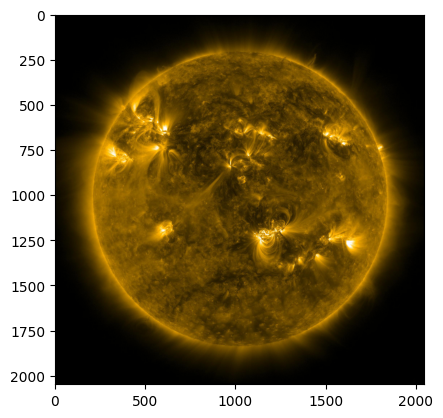

In [ ]:
data_dir_1 = './data/exploration/explore-1_2011-02-15T01:44:00/'
aia_wave = 171
images = list(Path(data_dir_1).rglob(f'*__{aia_wave}.jpeg'))
img_path = images[0]

src_img = Image.open(img_path)
plt.imshow(np.asarray(src_img))

Lets illustrate the image sequence of the example

In [ ]:
def display_images_with_filenames(folder_path):
    # Get the list of image filenames in the folder
    image_filenames = os.listdir(folder_path)
    num_images = len(image_filenames)

    # Calculate the number of rows and columns based on the square root of the total number of images
    num_cols = int(num_images**0.5)
    num_rows = (num_images + num_cols - 1) // num_cols

    # Set the spacing between subplots
    spacing = 0.1

    # Create a figure and subplots with appropriate dimensions
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

    # Iterate over the image filenames and display them in subplots
    for i, filename in enumerate(image_filenames):
        # Get the full path to the image file
        image_path = os.path.join(folder_path, filename)

        # Load the image using Matplotlib
        img = mpimg.imread(image_path)

        # Get the current subplot
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]

        # Display the image and set the subplot title as the filename
        ax.imshow(img)
        ax.set_title(filename)

        # Remove axis ticks and labels
        ax.axis('off')

        # Set the aspect ratio of each subplot to 'equal'
        ax.set_aspect('equal')

    # Adjust the spacing between subplots
    fig.subplots_adjust(wspace=spacing, hspace=spacing)

    # Save the image sequenze
    img_name = 'sequenze.jpeg'
    img_save = folder_path + img_name
    plt.savefig(img_save, bbox_inches = 'tight')
    print('Image saved as ', img_name)

    # Show the plot
    plt.show()


Image saved as  sequenze.jpeg


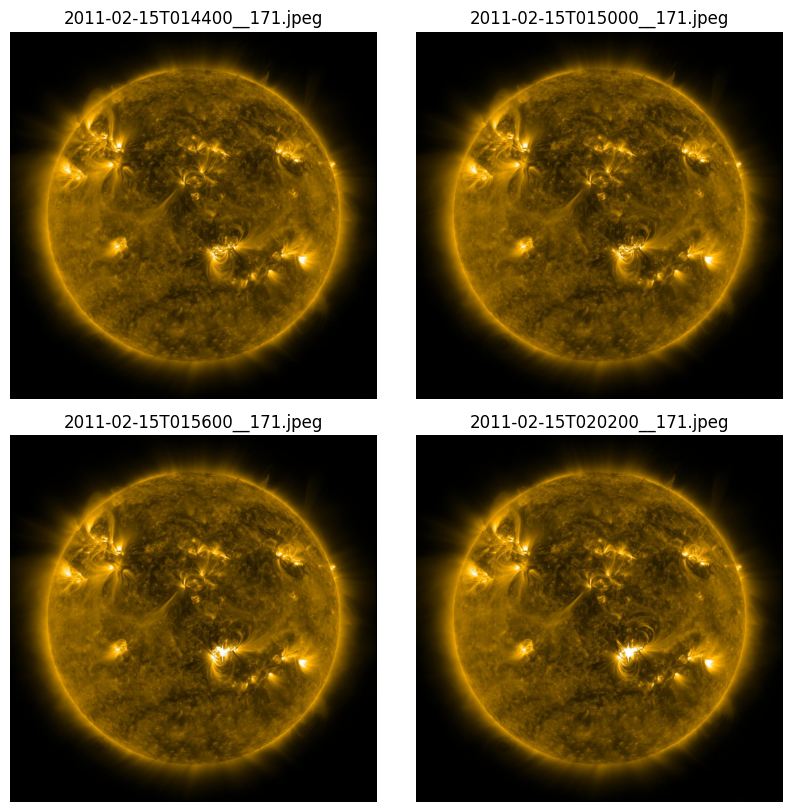

In [ ]:
display_images_with_filenames(data_dir_1)

As one can see from the above image sequence it is almost impossible (or at least very hard) for a human eye to see the differences between each image.
### Example 2: Same as Example 1, but with ΔT=60 min
Let us now try do illustrate the same event, however with a time cadence of one hour. Therfore, we add we begin approximately two hour earlier from the start time and end about one hour after the end time.

start = 2011-02-15 T00:00:00 \\
end   = 2011-02-15 T03:00:00 \\
freq  = 60 min \\
wavelength = 171A

In [ ]:
!sdo-cli data download --path='./data/exploration/explore-2_2011-02-15T00:00:00/' --start='2011-02-15T00:00:00' --end='2011-02-15T03:00:00' --freq='60min' --wavelength='171' #original

2023-07-24 16:10:57,848 numexpr.utils    INFO Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-07-24 16:10:57,848 numexpr.utils    INFO NumExpr defaulting to 8 threads.
2023-07-24 16:10:59,738 sdo.cli          INFO Starting to download images...
2023-07-24 16:10:59,740 sdo.cli          INFO loading data for 4 images between 2011-02-15 00:00:00 and 2011-02-15 03:00:00 for wavelengths ('171',)
100% 4/4 [00:00<00:00, 25343.23it/s]


Image saved as  sequenze.jpeg


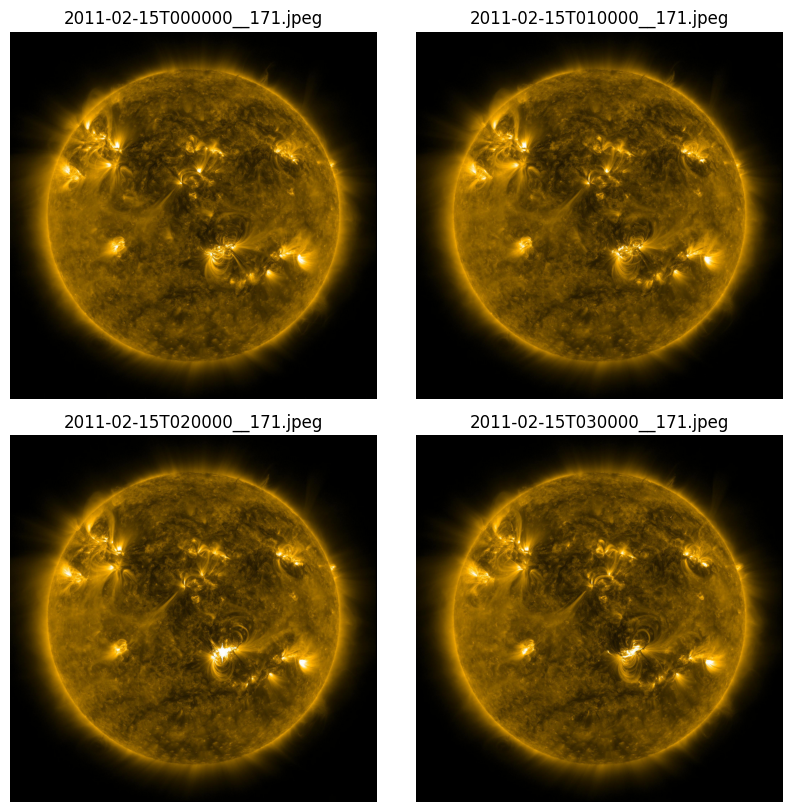

In [ ]:
data_dir_2 = './data/exploration/explore-2_2011-02-15T00:00:00/'
display_images_with_filenames(data_dir_2)

It is still quite challenging to see the difference. \\

### Example 3: Same as Example 1, but with ΔT=780 min
Lets try another example of the same CME: \\
start = 2011-02-14 T00:00:00 \\
end   = 2011-02-16 T00:00:00 \\
freq  = 780 min \\
wavelength = 171A

In [ ]:
!sdo-cli data download --path='./data/exploration/explore-3_2011-02-14T00:00:00/' --start='2011-02-14T00:00:00' --end='2011-02-16T00:00:00' --freq='780min' --wavelength='171' #original

2023-07-24 16:17:06,999 numexpr.utils    INFO Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-07-24 16:17:06,999 numexpr.utils    INFO NumExpr defaulting to 8 threads.
2023-07-24 16:17:08,945 sdo.cli          INFO Starting to download images...
2023-07-24 16:17:08,950 sdo.cli          INFO loading data for 4 images between 2011-02-14 00:00:00 and 2011-02-16 00:00:00 for wavelengths ('171',)
100% 4/4 [00:06<00:00,  1.66s/it]


Image saved as  sequenze.jpeg


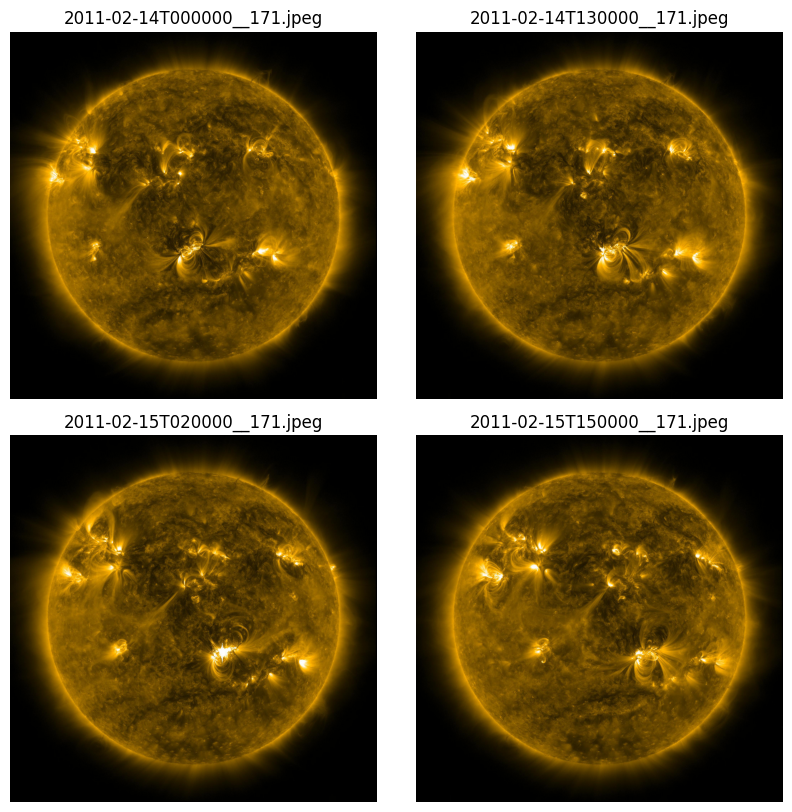

In [ ]:
data_dir_3 = './data/exploration/explore-3_2011-02-14T00:00:00/'
display_images_with_filenames(data_dir_3)

Now, changes within the corona are better visible. This brings us to the question: What is the appropriate time imterval (cadence) between images for our prediction task?

From the literature: 1h (

### Example 4: no CME assoc. w. Flare at 2017-09-05T03:42:00

start = 2017-09-05T03:42:00 \
end   = 2017-09-05T04:04:00 \
freq  = 6 min \\
wavelength = 171A

In [ ]:
!sdo-cli data download --path='./data/exploration/explore-4_2017-09-05T03:42:00/' --start='2017-09-05T03:42:00' --end='2017-09-05T04:04:00' --freq='6min' --wavelength='171'

2023-07-24 16:19:18,489 numexpr.utils    INFO Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-07-24 16:19:18,489 numexpr.utils    INFO NumExpr defaulting to 8 threads.
2023-07-24 16:19:20,415 sdo.cli          INFO Starting to download images...
2023-07-24 16:19:20,421 sdo.cli          INFO loading data for 4 images between 2017-09-05 03:42:00 and 2017-09-05 04:04:00 for wavelengths ('171',)
100% 4/4 [00:06<00:00,  1.59s/it]


Image saved as  sequenze.jpeg


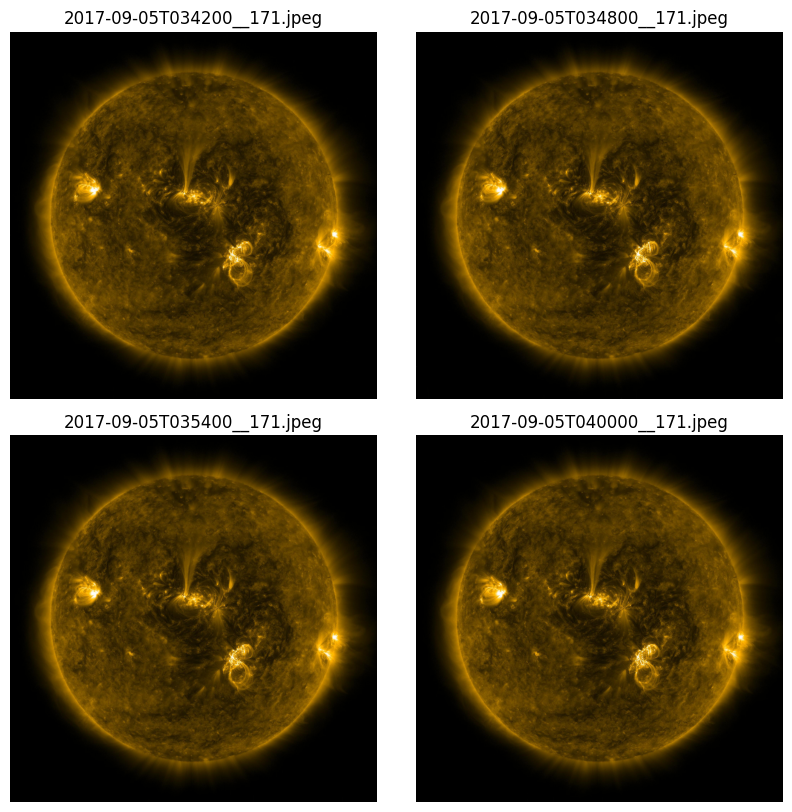

In [ ]:
data_dir_4 = './data/exploration/explore-4_2017-09-05T03:42:00/'
display_images_with_filenames(data_dir_4)